In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/nash_lxr_knockout/results/200910_LysMCre_AlphaFlox_AMLN20weeks_Cohort3_WholeLiver_RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Preprocess raw count matrix
Option to filter samples that don't pass QC / PCA

In [3]:
# read in gene expression
raw = pd.read_csv('./expression/rna_exp_raw.tsv', sep='\t', index_col=0)
tpm = pd.read_csv('./expression/rna_exp_tpm.tsv', sep='\t', index_col=0)

# drop samples if necessary
print('dropping samples')
print(raw.shape[1] - 7, 'samples')
# drop samples that don't have enough reads
dropsamp =['LLXR167A']
tpm = tpm.drop(axis=1, labels=tpm.columns[tpm.columns.to_series().str.contains('|'.join(dropsamp))])
raw = raw.drop(axis=1, labels=raw.columns[raw.columns.to_series().str.contains('|'.join(dropsamp))])
print(raw.shape[1] - 7, 'samples')


dropping samples
10 samples
9 samples


Check columns to ensure proper filtering

In [41]:
raw.columns

Index(['chr', 'start', 'end', 'strand', 'Length', 'Copies',
       'Annotation/Divergence',
       '/home/h1bennet/nash_lxr_knockout/data/mouse/RNA/lysm_alphaflox_amln_20wks_cohort3_wholeliver/00_mouse_CreNeg_M_WholeLiver_RNA_AMLNDiet_20weeks_LLXR163A_HBENN_l20200909_ATATGGAT_CTGTATTA (16186312.0 total)',
       '/home/h1bennet/nash_lxr_knockout/data/mouse/RNA/lysm_alphaflox_amln_20wks_cohort3_wholeliver/00_mouse_CreNeg_M_WholeLiver_RNA_AMLNDiet_20weeks_LLXR164A_HBENN_l20200909_AAGATACT_ACTTACAT (15770121.0 total)',
       '/home/h1bennet/nash_lxr_knockout/data/mouse/RNA/lysm_alphaflox_amln_20wks_cohort3_wholeliver/00_mouse_CreNeg_M_WholeLiver_RNA_AMLNDiet_20weeks_LLXR164B_HBENN_l20200909_GGAGCGTC_GTCCGTGC (13304466.0 total)',
       '/home/h1bennet/nash_lxr_knockout/data/mouse/RNA/lysm_alphaflox_amln_20wks_cohort3_wholeliver/00_mouse_CreNeg_M_WholeLiver_RNA_AMLNDiet_20weeks_LLXR164D_HBENN_l20200909_GCAATGCA_GGAACGTT (14725299.0 total)',
       '/home/h1bennet/nash_lxr_knockout/data/mo

The next step will filter based on tpm and require that average TPM within each group be > 2. To do this you need to manually set groups to match the columns in the count files. Alternatively you can use the two commented lines to instead require that at least two samples has TPM greater than a certain cutoff.

In [42]:
groups=[[7,8,9,10,11], [12,13,14,15]]

In [43]:
# drop small genes
print('dropping small genes')
print(raw.shape[0], 'total genes')
raw = raw.loc[raw.Length >= 250, :]
print(raw.shape[0], 'total genes')

# drop lowly expressed genes
print('dropping lowly expressed genes')
# use overall filter
tpm = tpm.loc[raw.index.values, :]
print(raw.shape[0], 'total genes')

# use simple tpm threshold.
# raw = raw.loc[(tpm.iloc[:, 7:] > 4).sum(1) > 1, :]

# use group based average tpm filter
genes = []
for group in groups:
    genes.extend(tpm.loc[tpm.iloc[:, group].mean(1) > 2, :].index.tolist())
raw = raw.reindex(list(set(genes)))
raw = raw.dropna(how='all')
print(raw.shape[0], 'total genes')

# write new gene list
raw.to_csv('./expression/rna_exp_raw_filtered.tsv', sep='\t')

dropping small genes
24940 total genes
23594 total genes
dropping lowly expressed genes
23594 total genes
11852 total genes


# Run differential gene analysis

In [45]:
%%bash
source activate deseq_36
getDiffExpression.pl ./expression/rna_exp_raw_filtered.tsv \
00_creneg_wholeliver_20weeks 00_creneg_wholeliver_20weeks 00_creneg_wholeliver_20weeks 00_creneg_wholeliver_20weeks 00_creneg_wholeliver_20weeks \
01_lysmcre_wholeliver_20weeks 01_lysmcre_wholeliver_20weeks 01_lysmcre_wholeliver_20weeks 01_lysmcre_wholeliver_20weeks > ./expression/diff_output.txt


	Autodetecting input file format...
	Autodetected analyzeRepeats.pl file

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_creneg_wholeliver_20weeks vs. 01_lysmcre_wholeliver_20weeks:
		Total Genes: 11852
		Total Up-regulated in 01_lysmcre_wholeliver_20weeks vs. 00_creneg_wholeliver_20weeks: 0 (0.000%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_lysmcre_wholeliver_20weeks vs. 00_creneg_wholeliver_20weeks: 1 (0.008%) [log2fold<-1, FDR<0.05]



## Import differential gene analysis results

In [4]:
diff_gene, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
    './expression/diff_output.txt',
    './expression/rna_exp_tpm.tsv',
    gene_name_index=True)

diff_gene = diff_gene.loc[~(diff_gene.chr.str.contains('chrX|chrY')), :]

tpm = tpm.drop(axis=1, labels=tpm.columns[tpm.columns.to_series().str.contains('|'.join(dropsamp))])
tpm_mat = tpm_mat.drop(axis=1, labels=tpm_mat.columns[tpm_mat.columns.to_series().str.contains('|'.join(dropsamp))])
tpm = tpm_mat_quant.drop(axis=1, labels=tpm_mat_quant.columns[tpm_mat_quant.columns.to_series().str.contains('|'.join(dropsamp))])


ge all transcripts (40458, 17)
Diff Gene selected transcripts (11852, 19)
ge selected transcripts (11852, 17)


## Turn comparisons into dictionary of each pairwise comparison.

In [5]:
comp_dict = pull_comparisons_get_diff(diff_gene=diff_gene)

In [6]:
de = comp_dict['00_creneg_wholeliver_20weeks vs. 01_lysmcre_wholeliver_20weeks']
de = de.sort_values('adj_pval', ascending=True)

In [51]:
de.head()

,RepeatID,log2fc,pval,adj_pval
gene,,,,
Spp1,NM_001204201,-0.588645,0.24022,0.999734


# Summarize result (logFC vs Mean TPM)

This also requires some manual curation. Fill the lists below as follows:

* comps: Name of each comp in comp_dict that you'd like to have plotted.
* cols: all columns of samples in tpm_mat that have samples in the comparison.
* groups: paired lists of the samples in group A that are compared to group b.
* colors: colors you would like associated with group A or group B differential genes.

In [ ]:
comps = ['00_creneg_wholeliver_20weeks vs. 01_lysmcre_wholeliver_20weeks']
cols = [[0,1,2,3,4,5,6,7,8]]

groups = [[[0,1,2,3,4],[5,6,7,8]]]

colors = [['#e41a1c', '#377eb8']]

## Make volcano plot and scatter plot

00_creneg_wholeliver_20weeks vs. 01_lysmcre_wholeliver_20weeks
N genes downregulated 1
N genes upregulated 0


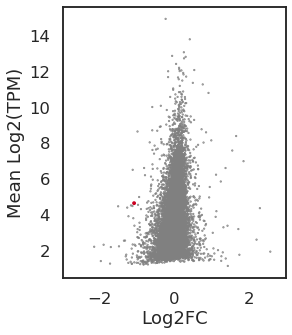

In [52]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in tpm_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(tpm_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < 0)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 0)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(5,5))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,14.5,
        s='%d %s spec genes' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(14.5,0.5,
        s='%d %s spec genes' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

# Write differential genes for metascape

In [55]:
#### Write gene list for analysis with metascape
pval = 0.05 # p value cutoff
log2fc = 0 # fc cutoff for interesting genes

if not os.path.isdir('./gene_lists'):
    os.mkdir('./gene_lists')

for key, diff in comp_dict.items():
    
    up = ( comp_dict[key].adj_pval <= pval ) & \
    ( comp_dict[key].log2fc >= log2fc )
    
    dn = ( comp_dict[key].adj_pval <= pval ) & \
    ( comp_dict[key].log2fc <= -log2fc )
    
    with open('./gene_lists/'+key+'_up_log2fc%.2f_p%.2f.txt' % (log2fc, pval), 'w') as f:
        f.write('gene\n')
        for val in up[up].index.values:
            f.write(val+'\n')
        f.close()

    with open('./gene_lists/'+key+'_dn_log2fc%.2f_p%.2f.txt' % (log2fc, pval), 'w') as f:
        f.write('gene\n')
        for val in dn[dn].index.values:
            f.write(val+'\n')
        f.close()

# Plot differential genes

If few differential genes then seaborn barplot should work

In [56]:
de = comp_dict['00_creneg_wholeliver_20weeks vs. 01_lysmcre_wholeliver_20weeks']
de = de.sort_values('adj_pval', ascending=True)

In [57]:
de['direction'] = ['up' if i > 0 else 'down' for i in de.log2fc]

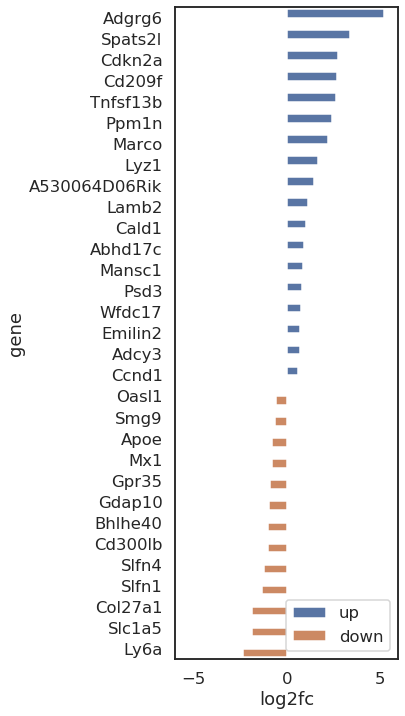

In [58]:
f, ax = plt.subplots(figsize=(4, 12))

sns.barplot(x="log2fc", y="gene", hue='direction',
            data=de.loc[de.adj_pval <= 0.05, :].sort_values('log2fc', ascending=False).reset_index(),
            ax=ax)

ax.set_xlim([-6, 6])
ax.legend(loc="lower right", frameon=True)

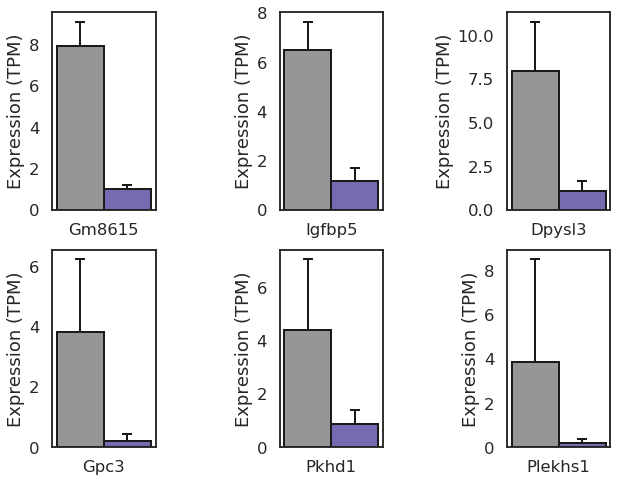

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(10,8))
plt.subplots_adjust(wspace=1.2)
genes = ['Gm8615', 'Igfbp5', 'Dpysl3', 'Gpc3', 'Pkhd1', 'Plekhs1']

for ax, gene in zip(axs.flatten(), genes):
    gene_list_bar_plot([gene],
                       data=tpm_mat,
                       groups=[[0,1,2,3,4],[5,6,7,8]],
                       group_labels=['CreNeg', 'LysMCre-LXRAFlox'],
                       colors=['#969696', '#756bb1'],
                       width=0.25,
                       ax=ax)
    ax.get_legend().remove()

### Upregulated genes

In [11]:
collagens = ['Col1a1', 'Col1a2', 'Col4a2',
             'Col4a5', 'Col5a2', 'Col6a1',
             'Col6a2', 'Col6a3', 'Col15a1']

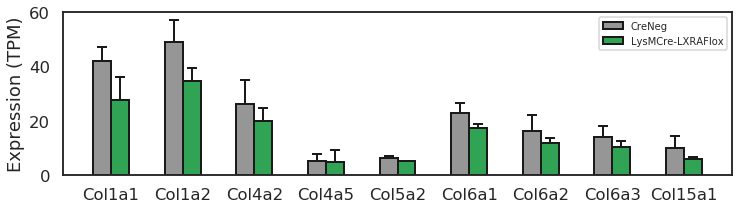

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))

gene_list_bar_plot(collagens,
                   data=tpm_mat,
                   groups=[[0,1,2,3,4],[5,6,7,8]],
                   group_labels=['CreNeg', 'LysMCre-LXRAFlox'],
                   colors=['#969696', '#31a354'],
                   relative=False,
                   width=0.25,
                   ax=ax)

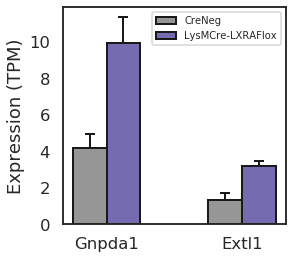

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

gene_list_bar_plot(['Gnpda1', 'Extl1'],
                   data=tpm_mat,
                   groups=[[0,1,2,3,4],[5,6,7,8]],
                   group_labels=['CreNeg', 'LysMCre-LXRAFlox'],
                   colors=['#969696', '#756bb1'],
                   relative=False,
                   width=0.25,
                   ax=ax)

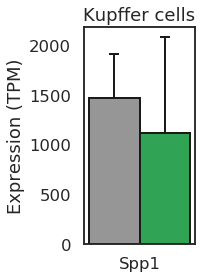

In [14]:
fig, ax = plt.subplots(figsize=(2,4))
gene_list_bar_plot(['Spp1'],
                   data=tpm_mat,
                   groups=[[[0,1,2,3,4],[5,6,7,8]],
                   width=0.2,
                   group_labels=['CreNeg', 'LysMCre-LXRAFlox'],
                   colors=['#969696', '#31a354'])
ax.set_title('Kupffer cells')
ax.get_legend().remove()
# plt.savefig('./figures/spp1_exp.png', bbox_inches='tight')